In [ ]:
# System & OS
import os
import sys

# Data Handling
import pandas as pd
import numpy as np

# PyTorch & Model Handling
import torch
import torchvision.transforms as transforms
import torch.nn as nn

# Sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Image Processing
from PIL import Image

# Visualization
import matplotlib.pyplot as plt

# Import gDrive Components
from google.colab import drive
drive.mount('/content/drive/')

# Change directory
os.chdir('/content/drive/MyDrive/BRSET')
import models_vit
from pos_embed import interpolate_pos_embed
from timm.layers import trunc_normal_

# Print processing hardware
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))

Mounted at /content/drive/
PyTorch Version: 2.5.1+cu124
CUDA Available: False
Device: cpu


In [ ]:
# Load the BRSET dataset CSV file
csv_path = "labels_brset.csv"
df = pd.read_csv(csv_path, low_memory=False)

# Total patients records
print(f"Total patients records: {df.shape[0]}")

# Convert 'diabetes' column to lowercase & strip spaces
df["diabetes"] = df["diabetes"].str.lower().str.strip()

# Filter only diabetic patients
df = df[df["diabetes"] == "yes"]

# Display dataset info
print(f"\nDataset Loaded: {csv_path}")
print(f"Total diabetic patients: {df.shape[0]}")
print("\n Dataset Info:")
print(df.info())

# Check for missing values
print("\n Missing Values:")
print(df.isnull().sum().sort_values(ascending=False))

Total patients records: 16266

Dataset Loaded: labels_brset.csv
Total diabetic patients: 2579

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 2579 entries, 0 to 16265
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  2579 non-null   object 
 1   patient_id                2579 non-null   int64  
 2   camera                    2579 non-null   object 
 3   patient_age               2579 non-null   float64
 4   comorbidities             2579 non-null   object 
 5   diabetes_time_y           1910 non-null   object 
 6   insuline                  1712 non-null   object 
 7   patient_sex               2579 non-null   int64  
 8   exam_eye                  2579 non-null   int64  
 9   diabetes                  2579 non-null   object 
 10  nationality               2579 non-null   object 
 11  optic_disc                2579 non-null   object 
 12  vessels     

In [ ]:
# Remove rows with missing values in key columns
df.dropna(subset=["diabetes_time_y", "insuline"], inplace=True)

# Fix common OCR errors (e.g., letter "O" misread as zero)
df["diabetes_time_y"] = df["diabetes_time_y"].str.replace("O", "0")

# Convert comma-based decimals to dots for numerical processing
df["diabetes_time_y"] = df["diabetes_time_y"].str.replace(",", ".")

# Convert the cleaned string column to numeric (float), coercing errors to NaN
df["diabetes_time_y"] = pd.to_numeric(df["diabetes_time_y"], errors="coerce")

# Convert diabetes duration:
# - If value is 1 or more, assume it's in years and convert to months (years * 12)
# - If value is less than 1, assume it's already in months (e.g., 0.5 = 5 months)
df["diabetes_time_y"] = df["diabetes_time_y"].apply(lambda x: int(x * 12) if x >= 1 else int(x * 10))

# Convert insulin usage to binary (1 = Yes, 0 = No)
df["insuline"] = df["insuline"].str.lower().map({"yes": 1, "no": 0})

# Display dataset info after transformations
print("\nUpdated Dataset Info:")
print(df.info())


Updated Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Index: 1551 entries, 0 to 16263
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_id                  1551 non-null   object 
 1   patient_id                1551 non-null   int64  
 2   camera                    1551 non-null   object 
 3   patient_age               1551 non-null   float64
 4   comorbidities             1551 non-null   object 
 5   diabetes_time_y           1551 non-null   int64  
 6   insuline                  1551 non-null   int64  
 7   patient_sex               1551 non-null   int64  
 8   exam_eye                  1551 non-null   int64  
 9   diabetes                  1551 non-null   object 
 10  nationality               1551 non-null   object 
 11  optic_disc                1551 non-null   object 
 12  vessels                   1551 non-null   int64  
 13  macula                    1551 non-null   in


Insulin Usage Counts:
insuline
1    834
0    717
Name: count, dtype: int64

Diabetes Duration Statistics:
count    1551.000000
mean      159.742747
std       117.133754
min         1.000000
25%        60.000000
50%       120.000000
75%       240.000000
max       720.000000
Name: diabetes_time_y, dtype: float64


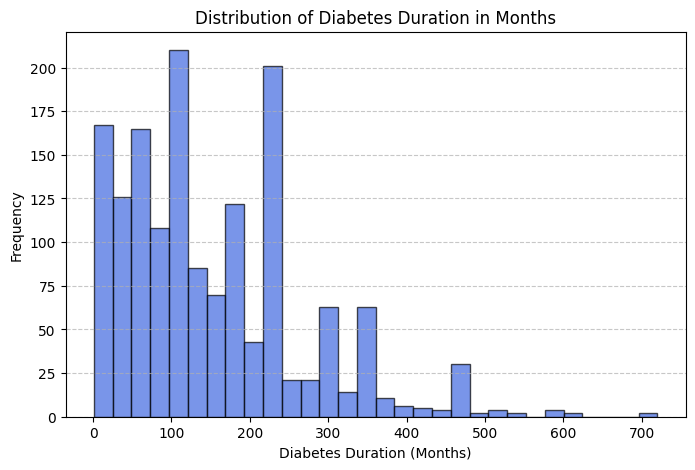

In [ ]:
# Display count of insulin usage (1 = Yes, 0 = No)
print("\nInsulin Usage Counts:")
print(df["insuline"].value_counts())

# Display summary statistics for diabetes duration (in months)
print("\nDiabetes Duration Statistics:")
print(df["diabetes_time_y"].describe())

# Plot histogram of diabetes duration (in months)
plt.figure(figsize=(8, 5))
plt.hist(df["diabetes_time_y"], bins=30, edgecolor="black", alpha=0.7, color="royalblue")
plt.xlabel("Diabetes Duration (Months)")
plt.ylabel("Frequency")
plt.title("Distribution of Diabetes Duration in Months")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()

In [ ]:
# Summarize diabetes duration separately for insulin users and non-users
treatment_stats = df[df["insuline"] == 1]["diabetes_time_y"].describe()
control_stats = df[df["insuline"] == 0]["diabetes_time_y"].describe()

print("\nDiabetes Duration Summary (in Months)")
print("-" * 40)
print("Treatment Group (Insulin Users):")
print(treatment_stats.to_string())

print("\nControl Group (Non-Insulin Users):")
print(control_stats.to_string())


Diabetes Duration Summary (in Months)
----------------------------------------
Treatment Group (Insulin Users):
count    834.000000
mean     187.395683
std      118.460206
min        2.000000
25%      108.000000
50%      168.000000
75%      240.000000
max      720.000000

Control Group (Non-Insulin Users):
count    717.000000
mean     127.577406
std      107.000685
min        1.000000
25%       48.000000
50%       96.000000
75%      180.000000
max      540.000000


In [ ]:
# Objective: we are estimating propensity scores using logistic regression
# to later perform matching between insulin users and non-users.

# Why This Is Important:
# Propensity scores help balance confounders before comparing treatment effects.
# Matching ensures fair comparison between insulin users and non-users, reducing bias.
# Standardization improves model stability, especially when features have different scales.

# # Step 1: Select confounders (variables that may affect insulin use)
# confounders = ["diabetes_time_y", "patient_age"]

# Step 2: Standardize confounders for better model performance
scaler = StandardScaler()
X = scaler.fit_transform(df[["diabetes_time_y", "patient_age"]])  # Transformed confounders
y = df["insuline"]  # Treatment variable (1 = Insulin user, 0 = Non-user)

# Step 3: Fit logistic regression model to estimate propensity scores
ps_model = LogisticRegression()
ps_model.fit(X, y)

# Step 4: Compute propensity scores (probability of being in treatment group)
df["propensity_score"] = ps_model.predict_proba(X)[:, 1]

# Display first 10 rows with insulin status and assigned propensity scores
df[["insuline", "propensity_score"]].head(10)


,insuline,propensity_score
0,1,0.707226
1,1,0.707226
2,1,0.951224
3,1,0.951224
4,1,0.956654
5,1,0.956654
6,1,0.868487
7,1,0.868487
8,1,0.983543
9,1,0.983543


In [ ]:
# Objective: We are matching insulin users (treated group) with non-users (control
# group) using propensity scores to ensure a fair comparison for causal inference.

# Why This Is Important:
# Reduces bias by making treated and control groups comparable.
# Ensures that differences in outcomes are due to treatment (insulin use) rather than confounders.
# Uses nearest-neighbor matching based on propensity scores to find the most
# similar non-user for each insulin user.

# Step 1: Separate treatment and control groups
treated = df[df["insuline"] == 1].copy()
control = df[df["insuline"] == 0].copy()

# Step 2: Fit Nearest Neighbors model on control group using propensity scores
nn = NearestNeighbors(n_neighbors=1, metric="euclidean")
nn.fit(control[["propensity_score"]])

# Step 3: Find the closest match for each treated individual
distances, indices = nn.kneighbors(treated[["propensity_score"]])

# Step 4: Retrieve matched control individuals
matched_control = control.iloc[indices.flatten()].reset_index(drop=True)

# Step 5: Combine treated and matched control groups to create a balanced dataset
matched_df = pd.concat([treated.reset_index(drop=True), matched_control], axis=0).reset_index(drop=True)

# Step 6: Verify balance (should be equal counts for both groups)
print(matched_df["insuline"].value_counts())


insuline
1    834
0    834
Name: count, dtype: int64


In [ ]:
# Compare mean values of confounders before and after matching
print("Before Matching:")
print(df.groupby("insuline")[["diabetes_time_y", "patient_age"]].mean().round(2))

print("\nAfter Matching:")
print(matched_df.groupby("insuline")[["diabetes_time_y", "patient_age"]].mean().round(2))


Before Matching:
          diabetes_time_y  patient_age
insuline                              
0                  127.58        67.57
1                  187.40        44.63

After Matching:
          diabetes_time_y  patient_age
insuline                              
0                  285.97        58.03
1                  187.40        44.63


In [ ]:
caliper = 0.03  # Enforce max distance for better matches

# Ensure copies to avoid modifying original DataFrame
treated = df[df["insuline"] == 1].copy()
control = df[df["insuline"] == 0].copy()

# Assign unique keys for tracking
treated["key"] = np.arange(len(treated))

# Function to find closest match within the caliper range
def find_best_match(ps, treated_df):
    distances = (treated_df["propensity_score"] - ps).abs()
    min_index = distances.idxmin()

    return treated_df.loc[min_index, "key"] if distances[min_index] <= caliper else np.nan

# Apply function to find best match for each control patient
matched_control = control.copy()
matched_control["key"] = matched_control["propensity_score"].apply(lambda ps: find_best_match(ps, treated))

# Drop unmatched controls (outside caliper range)
matched_control.dropna(subset=["key"], inplace=True)

# Merge treated & matched control groups
matched_df = treated.merge(matched_control, on="key", suffixes=("_treated", "_control"))
matched_df.drop(columns=["key"], inplace=True)

# Verify improved balance
print("\nAfter Matching (Improved Balance):")
print(matched_df.groupby("insuline_treated")[["diabetes_time_y_treated", "patient_age_treated"]].mean().round(2))
print(matched_df.groupby("insuline_control")[["diabetes_time_y_control", "patient_age_control"]].mean().round(2))



After Matching (Improved Balance):
                  diabetes_time_y_treated  patient_age_treated
insuline_treated                                              
1                                  151.15                69.71
                  diabetes_time_y_control  patient_age_control
insuline_control                                              
0                                  128.55                67.39


In [ ]:
print("\nDistribution of DR Severity After Matching:")
print(matched_df.groupby("insuline_treated")["DR_ICDR_treated"].value_counts(normalize=True))
print(matched_df.groupby("insuline_control")["DR_ICDR_control"].value_counts(normalize=True))

# Save matched dataset
matched_csv_path = "/content/drive/MyDrive/BRSET/matched_brset.csv"
matched_df.to_csv(matched_csv_path, index=False)
print(f"✅ Matched dataset saved as {matched_csv_path}")



Distribution of DR Severity After Matching:
insuline_treated  DR_ICDR_treated
1                 0                  0.550704
                  4                  0.204225
                  2                  0.129577
                  1                  0.059155
                  3                  0.056338
Name: proportion, dtype: float64
insuline_control  DR_ICDR_control
0                 0                  0.847887
                  2                  0.085915
                  4                  0.040845
                  3                  0.014085
                  1                  0.011268
Name: proportion, dtype: float64
✅ Matched dataset saved as /content/drive/MyDrive/BRSET/matched_brset.csv


In [ ]:
matched_df["weight"] = matched_df.apply(
    lambda row: 1 / row["propensity_score_treated"] if row["insuline_treated"] == 1
    else 1 / (1 - row["propensity_score_control"]), axis=1
)

ate = (
    (matched_df["weight"] * matched_df["DR_ICDR_treated"]).sum() / matched_df["weight"].sum()
) - (
    (matched_df["weight"] * matched_df["DR_ICDR_control"]).sum() / matched_df["weight"].sum()
)

print(f"\nEstimated ATE (Effect of Insulin on DR Severity): {ate:.4f}")



Estimated ATE (Effect of Insulin on DR Severity): 0.6050


In [ ]:
num_patients = pd.concat([matched_df["patient_id_treated"], matched_df["patient_id_control"]]).nunique()
print(f"Total unique patients in the study: {num_patients}")


Total unique patients in the study: 481


In [ ]:
# Step 1: Ensure correct image-patient mapping
image_patient_map = pd.concat([
    matched_df[["image_id_treated", "patient_id_treated"]].rename(
        columns={"image_id_treated": "image_id", "patient_id_treated": "patient_id"}
    ),
    matched_df[["image_id_control", "patient_id_control"]].rename(
        columns={"image_id_control": "image_id", "patient_id_control": "patient_id"}
    )
], ignore_index=True)

# Step 2: Remove duplicate images that appear multiple times in control
image_patient_map = image_patient_map.drop_duplicates(subset=["image_id"]).reset_index(drop=True)

# Step 3: Count unique patients after deduplication
num_patients = image_patient_map["patient_id"].nunique()
print(f"Total unique patients in the study: {num_patients}")

# Step 4: Save unique matched image IDs
matched_image_ids = sorted(image_patient_map["image_id"].unique())

with open("matched_image_ids.txt", "w") as f:
    for img_id in matched_image_ids:
        f.write(f"{img_id}\n")

print(f"✅ Saved {len(matched_image_ids)} unique image IDs to matched_image_ids.txt")


Total unique patients in the study: 481
✅ Saved 820 unique image IDs to matched_image_ids.txt


In [ ]:
# Step 1: Set device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Step 2: Load the correct model architecture
model = models_vit.__dict__['vit_large_patch16'](
    num_classes=2,  # Number of output classes
    drop_path_rate=0.2,  # Regularization
    global_pool=""  # Leave empty or set to 'avg' if needed
).to(device)  # Move model to GPU if available

# Step 3: Load RetFound weights from Google Drive
weights_path = "/content/drive/MyDrive/BRSET/RETFound_cfp_weights.pth"  # Update path if needed
checkpoint = torch.load(weights_path, map_location=device)  # Load model on GPU/CPU

# Step 4: Extract model weights from checkpoint
checkpoint_model = checkpoint['model']
state_dict = model.state_dict()

# Step 5: Remove mismatched keys (classification layer)
for k in ['head.weight', 'head.bias']:
    if k in checkpoint_model and checkpoint_model[k].shape != state_dict[k].shape:
        print(f"Removing key {k} from pretrained checkpoint")
        del checkpoint_model[k]

# Step 6: Interpolate position embeddings
interpolate_pos_embed(model, checkpoint_model)

# Step 7: Load pre-trained model weights
msg = model.load_state_dict(checkpoint_model, strict=False)

# Step 8: Print missing keys instead of forcing an assertion
expected_missing_keys = {'head.weight', 'head.bias', 'fc_norm.weight', 'fc_norm.bias'}
if set(msg.missing_keys) != expected_missing_keys:
    print(f"⚠️ Unexpected missing keys: {msg.missing_keys}")
else:
    print("Model loaded with expected missing keys.")

# Step 9: Manually initialize the classifier layer
trunc_normal_(model.head.weight, std=2e-5)

# Step 10: Confirm model is loaded
print(f"RetFound Model Loaded Successfully on {device}!")


Using device: cpu


<ipython-input-110-2d008c30a427>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)  # Load model on GPU/CPU


⚠️ Unexpected missing keys: ['head.weight', 'head.bias']
RetFound Model Loaded Successfully on cpu!


In [ ]:
import os

# Define paths
image_folder = "/content/drive/MyDrive/BRSET/matched_images/"
matched_ids_file = "/content/drive/MyDrive/BRSET/matched_image_ids.txt"

# Check if the image folder exists
if not os.path.exists(image_folder):
    raise FileNotFoundError(f"❌ Image folder not found: {image_folder}")

# Load image IDs from the text file
with open(matched_ids_file, "r") as f:
    matched_image_ids = {line.strip() for line in f.readlines()}  # Use set for fast lookup

# Get image files from the folder
image_files = {img.split(".")[0] for img in os.listdir(image_folder)}  # Remove file extension

# Compare
missing_ids = matched_image_ids - image_files
extra_ids = image_files - matched_image_ids

# Print Summary
print(f"📂 Total unique image IDs in file: {len(matched_image_ids)}")
print(f"🖼️ Total image files in folder: {len(image_files)}")

# Handle missing images
if missing_ids:
    print(f"❌ Missing {len(missing_ids)} images. Showing first 5: {list(missing_ids)[:5]}")
else:
    print("✅ No missing images!")

# Handle extra images
if extra_ids:
    print(f"⚠️ Found {len(extra_ids)} extra images. Showing first 5: {list(extra_ids)[:5]}")
else:
    print("✅ No extra images!")


📂 Total unique image IDs in file: 820
🖼️ Total image files in folder: 220
❌ Missing 600 images. Showing first 5: ['img06013', 'img13846', 'img05602', 'img14745', 'img15587']
✅ No extra images!


In [ ]:
# good to go, go, go

In [ ]:
# Check available columns in image_patient_map
print("Columns in image_patient_map:", image_patient_map.columns)

# Verify sample rows
print("\nFirst few rows of image_patient_map:")
print(image_patient_map.head())

# Verify patient ID existence
if "patient_id" not in image_patient_map.columns:
    print("\n❌ patient_id column is missing!")
else:
    print("\n✅ patient_id column exists!")


Columns in image_patient_map: Index(['image_id', 'patient_id'], dtype='object')

First few rows of image_patient_map:
   image_id  patient_id
0  img00001           1
1  img00086          44
2  img00255         129
3  img00289         146
4  img00301         152

✅ patient_id column exists!


In [ ]:
print("Checking duplicates in matched_df...")
print(f"Total unique treated image IDs: {matched_df['image_id_treated'].nunique()}")
print(f"Total treated image IDs: {len(matched_df['image_id_treated'])}")

print(f"Total unique control image IDs: {matched_df['image_id_control'].nunique()}")
print(f"Total control image IDs: {len(matched_df['image_id_control'])}")


Checking duplicates in matched_df...
Total unique treated image IDs: 110
Total treated image IDs: 710
Total unique control image IDs: 710
Total control image IDs: 710


In [ ]:
print(matched_df["image_id_treated"].value_counts())


image_id_treated
img03912    51
img10409    31
img11382    31
img12990    21
img11082    19
            ..
img09765     2
img10305     2
img13112     1
img03170     1
img10834     1
Name: count, Length: 110, dtype: int64


In [ ]:
duplicates = matched_df["image_id_treated"].value_counts()
print(duplicates[duplicates > 1])


image_id_treated
img03912    51
img10409    31
img11382    31
img12990    21
img11082    19
            ..
img08609     2
img09333     2
img09397     2
img09765     2
img10305     2
Name: count, Length: 107, dtype: int64


In [ ]:
matched_df = matched_df.drop_duplicates(subset=["image_id_treated"], keep="first").reset_index(drop=True)


In [ ]:
print(matched_df["image_id_treated"].value_counts())


image_id_treated
img00001    1
img09746    1
img11082    1
img10834    1
img10755    1
           ..
img03772    1
img03685    1
img03256    1
img03214    1
img16215    1
Name: count, Length: 110, dtype: int64


In [ ]:
print(matched_df["image_id_control"].value_counts())


image_id_control
img07167    1
img01918    1
img00825    1
img02629    1
img01000    1
           ..
img01070    1
img07232    1
img01801    1
img11857    1
img15313    1
Name: count, Length: 110, dtype: int64


In [ ]:
print(f"Total unique patients: {matched_df['patient_id_treated'].nunique()} (Treated) & {matched_df['patient_id_control'].nunique()} (Control)")


Total unique patients: 110 (Treated) & 110 (Control)


In [ ]:
matched_image_ids = sorted(set(matched_df["image_id_treated"].tolist() + matched_df["image_id_control"].tolist()))

with open("matched_image_ids.txt", "w") as f:
    for img_id in matched_image_ids:
        f.write(f"{img_id}\n")

print(f"✅ Saved {len(matched_image_ids)} unique image IDs to matched_image_ids.txt")


✅ Saved 220 unique image IDs to matched_image_ids.txt


In [ ]:
matched_ids_file = "/content/drive/MyDrive/BRSET/matched_image_ids.txt"

with open(matched_ids_file, "r") as f:
    matched_image_ids = {line.strip() for line in f.readlines()}

image_files = {img.split(".")[0] for img in os.listdir(image_folder)}

missing_ids = matched_image_ids - image_files
extra_ids = image_files - matched_image_ids

print(f"Total unique image IDs in file: {len(matched_image_ids)}")
print(f"Total image files in folder: {len(image_files)}")

if missing_ids:
    print(f"❌ Missing {len(missing_ids)} images: {missing_ids}")
else:
    print("✅ No missing images!")

if extra_ids:
    print(f"⚠️ Found {len(extra_ids)} extra images: {extra_ids}")
else:
    print("✅ No extra images!")


Total unique image IDs in file: 220
Total image files in folder: 220
✅ No missing images!
✅ No extra images!


In [ ]:
original_images = set(df["image_id"].tolist())  # All images in the dataset
extra_but_in_data = extra_ids & original_images  # Extra images that exist in dataset

print(f"🔍 Extra images that exist in dataset: {len(extra_but_in_data)}")
print(f"⚠️ Extra images NOT found in dataset: {len(extra_ids - original_images)}")


🔍 Extra images that exist in dataset: 0
⚠️ Extra images NOT found in dataset: 0


In [ ]:
print(f"Unique Treated Images: {matched_df['image_id_treated'].nunique()}")
print(f"Unique Control Images: {matched_df['image_id_control'].nunique()}")
print(f"Total Images in matched_df: {len(matched_df)}")


Unique Treated Images: 110
Unique Control Images: 110
Total Images in matched_df: 110


In [ ]:
# Step 1: Extract correct matched images
matched_image_ids = sorted(set(matched_df["image_id_treated"].tolist() + matched_df["image_id_control"].tolist()))

# Step 2: Save matched image IDs
with open("matched_image_ids.txt", "w") as f:
    for img_id in matched_image_ids:
        f.write(f"{img_id}\n")

print(f"✅ Saved {len(matched_image_ids)} unique image IDs to matched_image_ids.txt")


✅ Saved 220 unique image IDs to matched_image_ids.txt


In [ ]:
# Step 1: Load the correct matched images
with open("matched_image_ids.txt", "r") as f:
    matched_image_ids = {line.strip() for line in f.readlines()}

# Step 2: Delete extra images
for img_file in os.listdir(image_folder):
    img_id = img_file.split(".")[0]  # Remove extension
    if img_id not in matched_image_ids:
        os.remove(os.path.join(image_folder, img_file))

print("✅ Removed all extra images!")


✅ Removed all extra images!


In [ ]:
# Get image files again
image_files = {img.split(".")[0] for img in os.listdir(image_folder)}

# Compare
missing_ids = matched_image_ids - image_files
extra_ids = image_files - matched_image_ids

if missing_ids:
    print(f"❌ Missing {len(missing_ids)} images: {missing_ids}")
else:
    print("✅ No missing images!")

if extra_ids:
    print(f"⚠️ Found {len(extra_ids)} extra images: {extra_ids}")
else:
    print("✅ No extra images!")


✅ No missing images!
✅ No extra images!


In [ ]:
model.eval()  # Set model to evaluation mode


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Id

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Function to process and get embeddings
def get_embedding(image_path):
    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_path}")
        return None  # Return None if file doesn't exist

    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)  # Add batch dimension
    device = "cuda" if torch.cuda.is_available() else "cpu"
    image = image.to(device)  # Move image to device

    model.eval()  # Ensure model is in eval mode
    with torch.no_grad():
        if hasattr(model, "forward_features"):  # Check if function exists
            embedding = model.forward_features(image)  # Extract features correctly
        else:
            embedding = model.norm(model.fc_norm(image))  # Alternative feature extraction

    return embedding.squeeze().cpu().numpy()  # Convert to NumPy array

# Test with a sample image
test_image_path = os.path.join(image_folder, f"{image_patient_map.iloc[0]['image_id']}.jpg")

# Ensure file exists
if os.path.exists(test_image_path):
    test_embedding = get_embedding(test_image_path)
    if test_embedding is not None:
        print(f"✅ Test embedding shape: {test_embedding.shape}")
else:
    print(f"❌ Image not found: {test_image_path}")


✅ Test embedding shape: (1024,)


In [ ]:
print(get_embedding(test_image_path))  # Should return a numerical vector


[-0.16119578  0.0480548   0.11086883 ... -0.13989957 -1.3272611
  0.23788254]


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image, UnidentifiedImageError
import pandas as pd
import numpy as np
import os

# Define image directory
image_folder = "/content/drive/MyDrive/BRSET/matched_images/"  # Update if needed

# Precompute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure model is in evaluation mode
model.eval()
model.to(device)  # Move model to the correct device

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Normalize
])

# Function to process and get embeddings
def get_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension & move to device

        with torch.no_grad():
            embedding = model(image)  # Get embedding

        return embedding.squeeze().cpu().numpy()

    except (UnidentifiedImageError, OSError) as e:
        print(f"⚠️ Skipping corrupted image: {image_path} ({e})")
        return None  # Return None if image can't be processed

# Load patient-image mapping
image_patient_map = pd.concat([
    matched_df[["image_id_treated", "patient_id_treated"]].rename(
        columns={"image_id_treated": "image_id", "patient_id_treated": "patient_id"}
    ),
    matched_df[["image_id_control", "patient_id_control"]].rename(
        columns={"image_id_control": "image_id", "patient_id_control": "patient_id"}
    )
], ignore_index=True)

# Ensure correct data types
image_patient_map["image_id"] = image_patient_map["image_id"].astype(str)
image_patient_map["patient_id"] = image_patient_map["patient_id"].astype(str)

# Storage for embeddings
embeddings_list = []

# Loop through each image and extract embeddings
for idx, row in image_patient_map.iterrows():
    image_id = row["image_id"]
    patient_id = row["patient_id"]
    image_path = os.path.join(image_folder, f"{image_id}.jpg")

    if os.path.exists(image_path):
        embedding = get_embedding(image_path)
        if embedding is not None:
            embeddings_list.append([image_id, patient_id] + embedding.tolist())
    else:
        print(f"⚠️ Missing image: {image_id}")

# Ensure at least one valid embedding before creating DataFrame
if embeddings_list:
    embedding_dim = len(embeddings_list[0]) - 2  # Subtract image_id and patient_id
    columns = ["image_id", "patient_id"] + [f"dim_{i}" for i in range(embedding_dim)]
    embeddings_df = pd.DataFrame(embeddings_list, columns=columns)

    # Save to CSV
    embeddings_csv_path = "/content/drive/MyDrive/BRSET/embeddings.csv"
    embeddings_df.to_csv(embeddings_csv_path, index=False)
    print(f"✅ Saved {len(embeddings_df)} embeddings to {embeddings_csv_path}")
else:
    print("❌ No embeddings were extracted. Check for missing/corrupt images.")


✅ Saved 220 embeddings to /content/drive/MyDrive/BRSET/embeddings.csv


In [ ]:
# Step 1: Stack treated and control image IDs with their patient IDs
matched_images = pd.concat([
    matched_df[["image_id_treated", "patient_id_treated"]].rename(
        columns={"image_id_treated": "image_id", "patient_id_treated": "patient_id"}
    ),
    matched_df[["image_id_control", "patient_id_control"]].rename(
        columns={"image_id_control": "image_id", "patient_id_control": "patient_id"}
    )
], ignore_index=True)

# Step 2: Merge embeddings with matched image-patient mapping
merged_embeddings = matched_images.merge(embeddings_df, on="image_id", how="inner")

# Step 3: Merge with matched_df using **image_id** instead of patient_id
full_merged_df = matched_df.merge(merged_embeddings, left_on=["image_id_treated"], right_on=["image_id"], how="inner")

# Step 4: Save final merged dataset
full_merged_csv_path = "/content/drive/MyDrive/BRSET/full_merged_brset.csv"
full_merged_df.to_csv(full_merged_csv_path, index=False)

print(f"✅ Full merged dataset saved as {full_merged_csv_path}")
print(f"🔍 Final dataset shape: {full_merged_df.shape}")


✅ Full merged dataset saved as /content/drive/MyDrive/BRSET/full_merged_brset.csv
🔍 Final dataset shape: (10244, 75)


In [ ]:
# Check embedding statistics
embedding_cols = [col for col in full_merged_df.columns if col.startswith("dim_")]
embedding_stats = full_merged_df[embedding_cols].describe().T

# Display statistics
print("\n🔍 Embedding Statistics:")
print(embedding_stats)



🔍 Embedding Statistics:
         count      mean       std       min       25%       50%       75%  \
dim_0  10244.0 -0.000388  0.000190 -0.000761 -0.000497 -0.000359 -0.000298   
dim_1  10244.0 -0.000298  0.000158 -0.000632 -0.000405 -0.000360 -0.000141   

            max  
dim_0  0.000260  
dim_1 -0.000033  


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


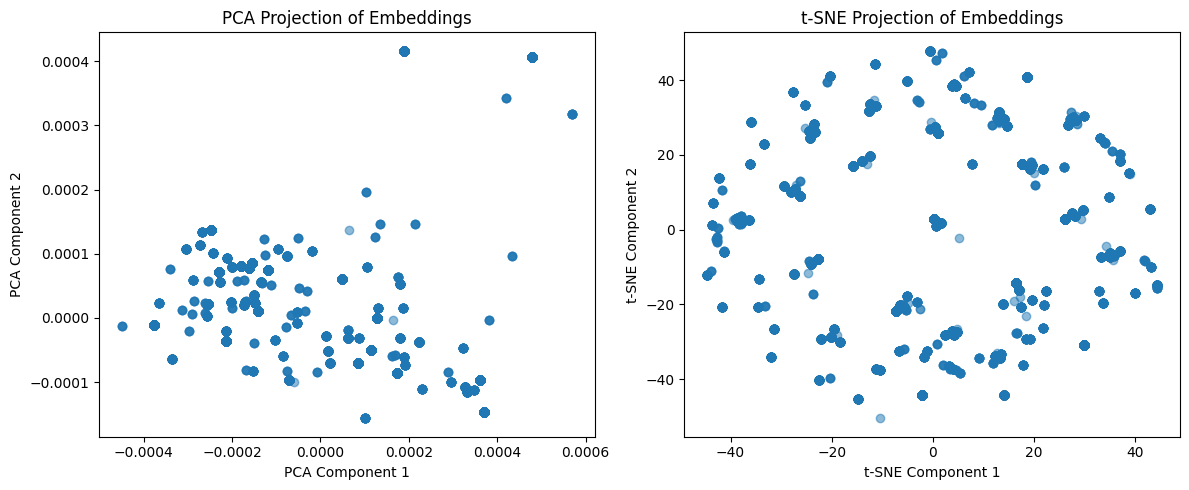

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Reduce dimensions for visualization
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(full_merged_df[embedding_cols])

tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=500)
tsne_proj = tsne.fit_transform(full_merged_df[embedding_cols])

# Plot PCA & t-SNE side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].scatter(pca_proj[:, 0], pca_proj[:, 1], alpha=0.5)
ax[0].set_title("PCA Projection of Embeddings")
ax[0].set_xlabel("PCA Component 1")
ax[0].set_ylabel("PCA Component 2")

ax[1].scatter(tsne_proj[:, 0], tsne_proj[:, 1], alpha=0.5)
ax[1].set_title("t-SNE Projection of Embeddings")
ax[1].set_xlabel("t-SNE Component 1")
ax[1].set_ylabel("t-SNE Component 2")

plt.tight_layout()
plt.show()


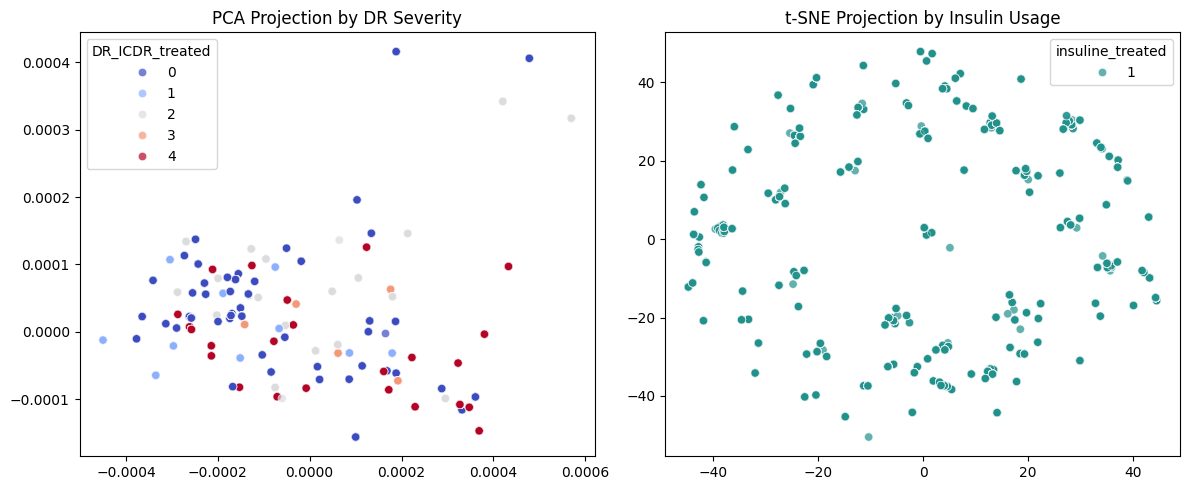

In [ ]:
import seaborn as sns

# Add labels
labels_dr = full_merged_df["DR_ICDR_treated"]  # Adjust column name if needed
labels_insulin = full_merged_df["insuline_treated"]  # Adjust if necessary

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# PCA colored by DR severity
sns.scatterplot(x=pca_proj[:, 0], y=pca_proj[:, 1], hue=labels_dr, palette="coolwarm", ax=ax[0], alpha=0.7)
ax[0].set_title("PCA Projection by DR Severity")

# t-SNE colored by insulin usage
sns.scatterplot(x=tsne_proj[:, 0], y=tsne_proj[:, 1], hue=labels_insulin, palette="viridis", ax=ax[1], alpha=0.7)
ax[1].set_title("t-SNE Projection by Insulin Usage")

plt.tight_layout()
plt.show()


In [ ]:
!pip install ace_tools_open

import numpy as np

# Select only numeric columns
numeric_cols = full_merged_df.select_dtypes(include=[np.number])

# Group by DR severity and compute mean differences
dr_groups = numeric_cols.groupby(full_merged_df["DR_ICDR_treated"]).mean()
dr_differences = dr_groups.diff().dropna()

# Group by insulin usage and compute mean differences
insulin_groups = numeric_cols.groupby(full_merged_df["insuline_treated"]).mean()
insulin_differences = insulin_groups.diff().dropna()

# Display differences
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Mean Embedding Differences (DR Severity)", dataframe=dr_differences)
tools.display_dataframe_to_user(name="Mean Embedding Differences (Insulin Usage)", dataframe=insulin_differences)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.0 MB/s eta 0:00:00
Mean Embedding Differences (DR Severity)


Mean Embedding Differences (Insulin Usage)


In [ ]:
# Check for incorrect data types
print(full_merged_df.dtypes)

# Ensure numerical columns are truly numeric
numerical_columns = full_merged_df.select_dtypes(include=["object"]).columns
print("\n🔍 Potential issues with these columns:", numerical_columns)

# Convert possible misinterpreted numerical columns
for col in numerical_columns:
    try:
        full_merged_df[col] = pd.to_numeric(full_merged_df[col], errors="coerce")
    except Exception as e:
        print(f"⚠️ Error converting {col}: {e}")

# Check again after conversion
print("\n✅ Updated column types:")
print(full_merged_df.dtypes)


image_id_treated          object
patient_id_treated         int64
camera_treated            object
patient_age_treated      float64
comorbidities_treated     object
                          ...   
image_id                  object
patient_id_x               int64
patient_id_y               int64
dim_0                    float64
dim_1                    float64
Length: 75, dtype: object

🔍 Potential issues with these columns: Index(['image_id_treated', 'camera_treated', 'comorbidities_treated',
       'diabetes_treated', 'nationality_treated', 'quality_treated',
       'image_id_control', 'camera_control', 'comorbidities_control',
       'diabetes_control', 'nationality_control', 'quality_control',
       'image_id'],
      dtype='object')

✅ Updated column types:
image_id_treated         float64
patient_id_treated         int64
camera_treated           float64
patient_age_treated      float64
comorbidities_treated    float64
                          ...   
image_id                 flo

In [ ]:
# List of categorical columns
categorical_columns = [
    "image_id_treated", "camera_treated", "comorbidities_treated",
    "diabetes_treated", "nationality_treated", "quality_treated",
    "image_id_control", "camera_control", "comorbidities_control",
    "diabetes_control", "nationality_control", "quality_control",
    "image_id"
]

# Convert back to string (fix corrupted float conversion)
for col in categorical_columns:
    full_merged_df[col] = full_merged_df[col].astype(str)

# Verify the fix
print("\n✅ Updated column types after fixing:")
print(full_merged_df.dtypes)



✅ Updated column types after fixing:
image_id_treated          object
patient_id_treated         int64
camera_treated            object
patient_age_treated      float64
comorbidities_treated     object
                          ...   
image_id                  object
patient_id_x               int64
patient_id_y               int64
dim_0                    float64
dim_1                    float64
Length: 75, dtype: object


In [ ]:
# Recalculate mean differences based on DR severity
dr_differences = full_merged_df.groupby("DR_ICDR_treated")[[f"dim_{i}" for i in range(2)]].mean()

# Recalculate mean differences based on insulin usage
insulin_differences = full_merged_df.groupby("insuline_treated")[[f"dim_{i}" for i in range(2)]].mean()

# Display results
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Mean Embedding Differences (DR Severity)", dataframe=dr_differences)
tools.display_dataframe_to_user(name="Mean Embedding Differences (Insulin Usage)", dataframe=insulin_differences)


Mean Embedding Differences (DR Severity)


Mean Embedding Differences (Insulin Usage)


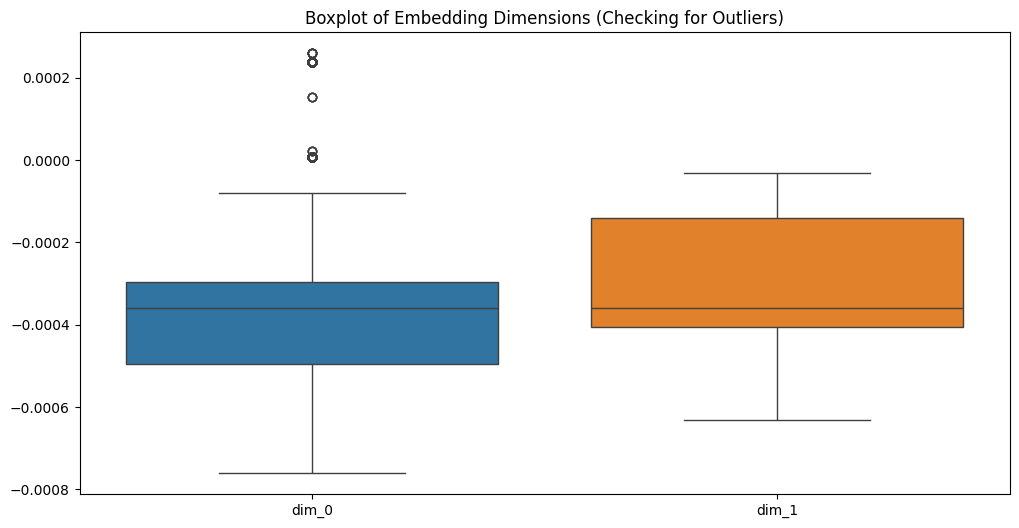

Embedding Statistics


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot for embedding dimensions
plt.figure(figsize=(12, 6))
sns.boxplot(data=full_merged_df[[f"dim_{i}" for i in range(2)]])
plt.title("Boxplot of Embedding Dimensions (Checking for Outliers)")
plt.show()

# Display basic stats
embedding_stats = full_merged_df[[f"dim_{i}" for i in range(2)]].describe()
tools.display_dataframe_to_user(name="Embedding Statistics", dataframe=embedding_stats)


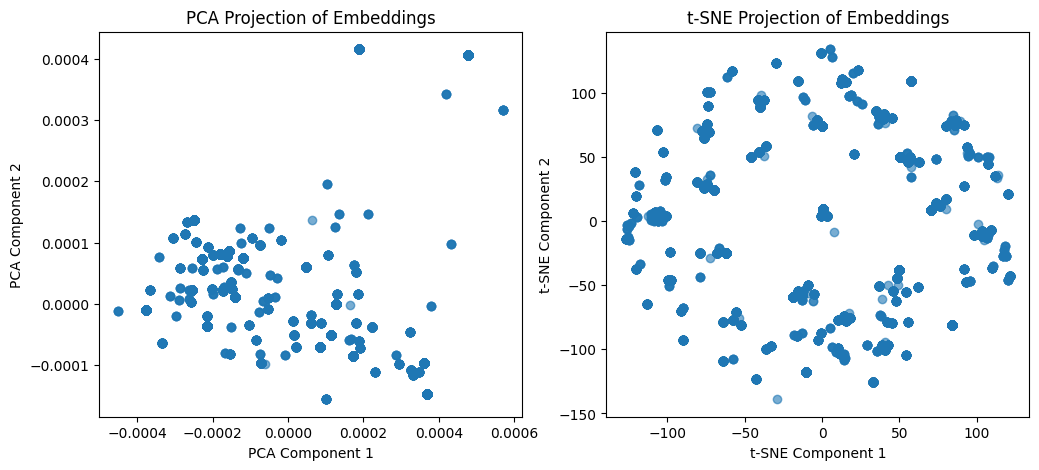

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Extract embeddings
embeddings = full_merged_df[[f"dim_{i}" for i in range(2)]].values

# PCA
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_proj = tsne.fit_transform(embeddings)

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# PCA Plot
axes[0].scatter(pca_proj[:, 0], pca_proj[:, 1], alpha=0.6)
axes[0].set_title("PCA Projection of Embeddings")
axes[0].set_xlabel("PCA Component 1")
axes[0].set_ylabel("PCA Component 2")

# t-SNE Plot
axes[1].scatter(tsne_proj[:, 0], tsne_proj[:, 1], alpha=0.6)
axes[1].set_title("t-SNE Projection of Embeddings")
axes[1].set_xlabel("t-SNE Component 1")
axes[1].set_ylabel("t-SNE Component 2")

plt.show()


In [ ]:
import scipy.stats as stats
import pandas as pd

# Define function to perform statistical tests
def perform_statistical_tests(df, group_col, embedding_cols):
    results = []

    unique_groups = df[group_col].unique()

    # Perform pairwise t-tests for each embedding dimension
    for dim in embedding_cols:
        group_data = [df[df[group_col] == group][dim].dropna() for group in unique_groups]
        if len(group_data) > 1:
            f_stat, p_anova = stats.f_oneway(*group_data)  # ANOVA for multiple groups
            results.append([dim, p_anova])

    # Convert results to DataFrame
    results_df = pd.DataFrame(results, columns=["Embedding Dimension", "p-value (ANOVA)"])
    return results_df

# Perform tests for DR severity
dr_severity_results = perform_statistical_tests(full_merged_df, "DR_ICDR_treated", ["dim_0", "dim_1"])

# Perform tests for insulin usage
insulin_usage_results = perform_statistical_tests(full_merged_df, "insuline_treated", ["dim_0", "dim_1"])

# Display results
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Statistical Test Results (DR Severity)", dataframe=dr_severity_results)
tools.display_dataframe_to_user(name="Statistical Test Results (Insulin Usage)", dataframe=insulin_usage_results)


Statistical Test Results (DR Severity)


Statistical Test Results (Insulin Usage)
